# 類別預測的任務

我們先載入這個章節範例程式碼中會使用到的第三方套件模組或者其中的部分函式、功能。

In [1]:
from pyvizml import CreateNBAData
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## 關於類別預測的任務

「類別預測」是「監督式學習」的其中一種應用類型，當預測的目標向量 $y$ 屬於離散型的類別變數，那我們就能預期正在面對類別預測的任務，它更廣泛被眾人知悉的名稱為「分類器」。例如預測的目標向量 $y$ 是 `player_stats` 資料中的 `pos`，在資料類別中屬於離散型的類別 `object`；具體來說，分類器想方設法地以一組係數向量 $w$ 計算特徵矩陣 $X$ 對應目標向量中每個類別的機率，再從中挑選出最高的機率來預測類別，與迴歸模型相同的是利用係數向量建構出用來逼近 $f$ 的 $h$，不同的是迴歸模型輸出的 $\hat{y}$ 就是預測值，而分類器所輸出的 $\hat{p}$ 僅是類別的預測機率，需要經過一個 $argmax$ 函式轉換為 $\hat{y}$。

我們也可依 [Tom Mitchel](https://en.wikipedia.org/wiki/Tom_M._Mitchell) 對機器學習電腦程式的定義寫下分類預測的資料、任務、評估與但書，以預測 `player_stats` 資料中的 `pos` 為例：

- 資料（Experience）：一定數量的球員資料
- 任務（Task）：利用模型預測球員的是前鋒或後衛
- 評估（Performance）：模型預測的鋒衛位置與球員實際鋒衛位置的誤分類數
- 但書（Condition）：隨著資料觀測值筆數增加，預測誤分類數應該要減少

In [2]:
# create_player_stats_df() 方法要對 data.nba.net 發出數百次的 HTTP 請求，等待時間會較長，要請讀者耐心等候
cnd = CreateNBAData(season_year=2019)
player_stats = cnd.create_player_stats_df()
player_stats['pos'].dtype

Creating players df...
Creating players df...
Creating player stats df...


dtype('O')

`player_stats` 資料中的 `pos` 有 7 個不同的類別：

In [3]:
print(player_stats['pos'].unique())
print(player_stats['pos'].nunique())

['G' 'C' 'C-F' 'F-C' 'F' 'F-G' 'G-F']
7


我們先將多元分類問題簡化為二元分類問題，鋒衛位置分作前鋒（F）與後衛（G），分別對應整數 1 與整數 0。

In [4]:
pos_dict = {
    0: 'G',
    1: 'F'
}
pos = player_stats['pos'].values
pos_binary = np.array([0 if p[0] == 'G' else 1 for p in pos])
np.unique(pos_binary)

array([0, 1])

## 以 Scikit-Learn 預測器完成類別預測任務

將 `apg` 與 `rpg` 當作特徵矩陣為例，特徵矩陣 $X$ 與目標向量 $y$ 之間的關聯可以這樣描述：

\begin{equation}
\hat{y} = 1, \quad if \: \hat{p}(y=1|X; w) \geq \hat{p}(y=0|X; w)
\end{equation}

\begin{equation}
\hat{y} = 0, \quad if \: \hat{p}(y=1|X; w) < \hat{p}(y=0|X; w)
\end{equation}

以 Scikit-Learn 定義好的預測器類別 `LogisticRegression` 可以計算特徵矩陣對應類別的預測機率。

In [5]:
X = player_stats[['apg', 'rpg']].values.astype(float)
y = pos_binary
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
h = LogisticRegression(C=1e06) # 預測器的正規化程度
h.fit(X_train, y_train)
print(h.intercept_)
print(h.coef_)

[-1.71621286]
[[-2.75507401  1.96609808]]


這裡需要說明初始化 `LogisticRegression` 類別指定參數 `C=1e5` 的用意。參數 `C` 用來描述預測器的正規化（Regularization）程度，當 `C` 愈大表示正規化效果愈低，反之 `C` 愈小表示正規化效果愈高，`LogisticRegression` 類別預設 `C=1` 這是具有正規化效果的參數設定，由於在本章節後段我們會自訂不具備正規化效果的 `LogitReg` 類別驗證我們對演算方法的理解，為了比較最適化的 $w$ 得先將 Scikit-Learn 模型的正規化效果降到很低。有關於「正規化」的技法，將在「表現的評估」章節中介紹給讀者認識，假如讀者目前感到困惑，可待讀過表現的評估等本書後面的章節，再回來複習。

`LogisticRegression` 類別的 `predict_proba` 方法輸出的數值陣列外觀為 `(m, n)`，其中 `m` 是特徵矩陣的觀測值個數，`n` 則是目標向量的獨一值，也就是類別的個數，以目前的二元分類（後衛 vs. 前鋒）問題來說，`n` 等於 2，第 0 欄是預測為類別 0 的機率 $\hat{p}(y=0|X; w)$、第 1 欄是預測為類別 1 的機率 $\hat{p}(y=1|X; w)$。

In [6]:
p_hat = h.predict_proba(X_valid)
p_hat[:10, :]

array([[1.24174853e-02, 9.87582515e-01],
       [9.99405251e-01, 5.94749246e-04],
       [6.13059991e-01, 3.86940009e-01],
       [3.53652646e-01, 6.46347354e-01],
       [3.81597551e-01, 6.18402449e-01],
       [3.01194136e-02, 9.69880586e-01],
       [8.47640386e-01, 1.52359614e-01],
       [2.47843181e-01, 7.52156819e-01],
       [8.14691640e-01, 1.85308360e-01],
       [4.77310176e-01, 5.22689824e-01]])

應用 `np.argmax` 函式回傳最大的欄位數，就能夠得到 $\hat{y}$。

In [7]:
y_pred = np.argmax(p_hat, axis=1)
y_pred[:10]

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1])

最後使用 `pos_dict` 將整數對應回鋒衛位置的文字外觀。

In [8]:
y_pred_label = [pos_dict[i] for i in y_pred]
y_pred_label[:10]

['F', 'G', 'G', 'F', 'F', 'F', 'G', 'F', 'G', 'F']

若是將 $h$ 的機率輸出在一個區間之內，例如在所有球員的場均助攻 `apg` 與場均籃板 `rpg` 均勻切割 50 個資料點，在平面上就可以對應出 2,500 個場均助攻和場均籃板的組合，每個組合都輸入 $h$ 得到一組機率組合 $\hat{p}(y=0|X; w)$ 與 $\hat{p}(y=1|X; w)$；假設將全部 2,500 個資料點的 $\hat{p}(y=1|X; w)$ 視作海拔高度、場均助攻視作經度、場均籃板視作緯度，我們可以描繪出一個填滿等高線圖（Contour-filled plot）。

In [9]:
resolution = 50
apg = player_stats['apg'].values.astype(float)
rpg = player_stats['rpg'].values.astype(float)
X1 = np.linspace(apg.min() - 0.5, apg.max() + 0.5, num=resolution).reshape(-1, 1)
X2 = np.linspace(rpg.min() - 0.5, rpg.max() + 0.5, num=resolution).reshape(-1, 1)
APG, RPG = np.meshgrid(X1, X2)

In [10]:
def plot_contour_filled(XX, YY, resolution=50):
    PROBA = np.zeros((resolution, resolution))
    for i in range(resolution):
        for j in range(resolution):
            xx_ij = XX[i, j]
            yy_ij = YY[i, j]
            X_plot = np.array([xx_ij, yy_ij]).reshape(1, -1)
            z = h.predict_proba(X_plot)[0, 1]
            PROBA[i, j] = z
    fig, ax = plt.subplots()
    CS = ax.contourf(XX, YY, PROBA, cmap='RdBu')
    ax.set_title("Probability of being predicted as a forward")
    ax.set_xlabel("Assists per game")
    ax.set_ylabel("Rebounds per game")
    fig.colorbar(CS, ax=ax)
    plt.show()

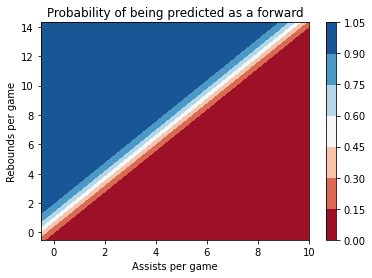

In [11]:
plot_contour_filled(APG, RPG)

從填滿等高線圖中我們可以看出場均籃板與被 $h$ 預測為前鋒的機率有正向的相關性、場均助攻與被 $h$ 預測為前鋒的機率有反向的相關性，這一點與場上籃球員的分工相符，擔任中鋒與大前鋒的球員比較擅長爭搶籃板球、擔任後衛的球員比較擅長傳球助攻；而圖中左下到右上有一段帶狀區間，被稱作「決策邊界」（Decision boundary），決策邊界能夠隨著門檻（Threshold）設定往左上角或右下角移動，預設的門檻多半設定在 50%，亦即由 $h$ 預測出的 $\hat{p}$ 如果大於 50%，就輸出 $\hat{y} = 1$，否則輸出 $\hat{y} = 0$。

In [12]:
def plot_decision_boundary(XX, YY, x, y, target_vector, pos_dict, h, resolution=50):
    Y_hat = np.zeros((resolution, resolution))
    for i in range(resolution):
        for j in range(resolution):
            xx_ij = XX[i, j]
            yy_ij = YY[i, j]
            X_plot = np.array([xx_ij, yy_ij]).reshape(1, -1)
            z = h.predict(X_plot)
            Y_hat[i, j] = z
    fig, ax = plt.subplots()
    CS = ax.contourf(XX, YY, Y_hat, alpha=0.2, cmap='RdBu')
    colors = ['red', 'blue']
    unique_categories = np.unique(target_vector)
    for color, i in zip(colors, unique_categories):
        xi = x[target_vector == i]
        yi = y[target_vector == i]
        ax.scatter(xi, yi, c=color, edgecolor='k', label="{}".format(pos_dict[i]), alpha=0.6)
    ax.set_title("Decision boundary of Forwards vs. Guards")
    ax.set_xlabel("Assists per game")
    ax.set_ylabel("Rebounds per game")
    ax.legend()
    plt.show()

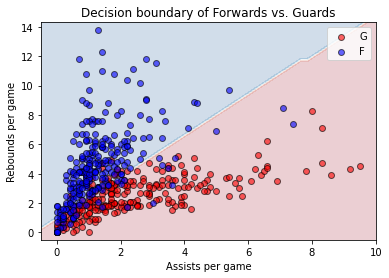

In [13]:
plot_decision_boundary(APG, RPG, apg, rpg, y, pos_dict, h)

再將特徵矩陣 $X$ 描繪在依據 $h$ 所得的決策邊界，就可以觀察到誤分類觀測值：藍色的資料點落在紅色的決策邊界（真實位置為前鋒、預測位置為後衛）、紅色的資料點落在藍色的決策邊界（真實位置為後衛、預測位置為前鋒）。
以 `LogisticRegression` 類別找出 $h$ 的最關鍵方法，與迴歸模型相同是呼叫 `fit()` 方法，究竟它是如何決定 `X_train` 與 `y_train` 之間的關聯？接下來我們試圖理解它。

## 羅吉斯迴歸

羅吉斯迴歸（Logistic Regression）分類器在機器學習領域中扮演著承先啟後的橋樑，能夠協助我們由數值預測過渡至類別預測的任務、再過渡至自動尋找特徵的深度學習。從前述例子中得知，欲得到對於特徵矩陣 $X$ 的類別預測 $\hat{y}$，必須先得到類別預測機率 $\hat{p}$，羅吉斯迴歸分類器透過 Sigmoid 函式（亦稱 S 函式、Logistic 函式），這裡使用 $\sigma$ 表示。

\begin{equation}
\hat{p} = \sigma(Xw) = \frac{1}{1 + e^{-Xw}}
\end{equation}

In [14]:
def sigmoid(x):
    return(1 / (1 + np.exp(-x)))

In [15]:
def plot_sigmoid():
    x = np.linspace(-6, 6, 100)
    y = sigmoid(x)
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(x, y)
    ax.axvline(0, color = 'black')
    ax.axhline(y = 0, ls = ':', color = 'k', alpha = 0.5)
    ax.axhline(y = 0.5, ls = ':', color = 'k', alpha = 0.5)
    ax.axhline(y = 1, ls = ':', color = 'k', alpha = 0.5)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_ylim(-0.1, 1.1)
    ax.set_title("Sigmoid function")
    plt.show()

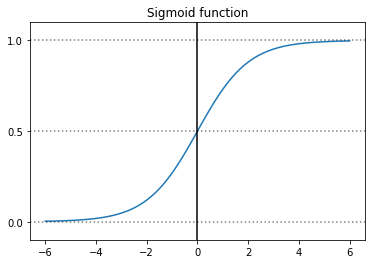

In [16]:
plot_sigmoid()

Sigmoid 函式將迴歸模型的輸出 $Xw$ 映射至 $[0, 1]$ 之間後我們就能獲得 $\hat{p}$，並依據門檻值獲得 $\hat{y}$。

\begin{equation}
\hat{y} = 1, \quad if \: \hat{p} \geq 0.5
\end{equation}

\begin{equation}
\hat{y} = 0, \quad if \: \hat{p} < 0.5
\end{equation}

截至於此，資料（Experiment）與任務（Task）已經被定義妥善，特徵矩陣 $X$ 外觀 `(m, n)`、目標向量 $y$ 外觀 `(m,)`、係數向量 $w$ 外觀 `(n,)`，通過將 $X$ 輸入 $h$ 來預測 $\hat{y}$，$h$ 的組成則可以拆解成 Sigmoid 函式 $\sigma$ 以及門檻值比較兩道程序，為了方便，我們將門檻值比較表示為階躍函式（Step function） $\chi$。

\begin{align}
\hat{y} &= h(X; w) \\
&= \chi(\sigma(Xw))
\end{align}

其中，

\begin{equation}
\sigma(x) = \frac{1}{1 + exp(-x)}
\end{equation}

\begin{equation}
\chi(z) = 1, \quad if \: z \geq 0.5
\end{equation}

\begin{equation}
\chi(z) = 0, \quad if \: z < 0.5
\end{equation}

接下來還需要定義評估（Performance），在數值預測任務中評估 $h$ 性能的方法是計算 $\hat{y}$ 與 $y$ 之間的均方誤差（Mean squared error），但是在類別預測任務中則是計算 $\hat{y}$ 與 $y$ 之間的誤分類觀測值個數，當誤分類數愈低，分類器的表現愈好。

\begin{equation}
Min. \sum_i \mid \hat{y}_i^{(train)} \neq y_i^{(train)} \mid
\end{equation}

羅吉斯迴歸使用交叉熵（Cross-entropy）函式作為量測 $J(w)$，這個函式的組成有兩個部分。

\begin{equation}
J(w) = -\frac{1}{m}log(\sigma(Xw)), \quad if \: y = 1
\end{equation}

\begin{equation}
J(w) = -\frac{1}{m}log(1-\sigma(Xw)), \quad if \: y = 0
\end{equation}

設計以交叉熵函式的巧妙之處在於讓誤分類的成本趨近無限大，亦即當真實的類別 $y$ 為 1，$\sigma(Xw)$ 若離 0 比較近，預測為類別 0 的機率較高，則成本將趨近無限大；而當真實的類別 $y$ 為 0，$\sigma(Xw)$ 若離 1 比較近，預測為類別 1 的機率較高則成本將趨近無限大。

In [17]:
def plot_cross_entropy():
    epsilon = 1e-5
    h = np.linspace(epsilon, 1-epsilon) # 利用微小值 epsilon 避免 log(0) 的錯誤
    y1 = -np.log(h)
    y2 = -np.log(1 - h)
    fig, ax = plt.subplots(1, 2, figsize = (8, 4))
    ax[0].plot(h, y1)
    ax[0].set_title("$y=1$\n$-\log(\sigma(Xw))$")
    ax[0].set_xticks([0, 1])
    ax[0].set_xticklabels([0, 1])
    ax[0].set_xlabel("$\sigma(Xw)$")
    ax[1].plot(h, y2)
    ax[1].set_title("$y=0$\n$-\log(1-\sigma(Xw))$")
    ax[1].set_xticks([0, 1])
    ax[1].set_xticklabels([0, 1])
    ax[1].set_xlabel("$\sigma(Xw)$")
    plt.tight_layout()
    plt.show()

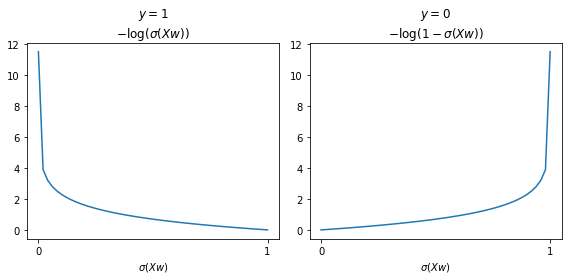

In [18]:
plot_cross_entropy()

將 $y$ 與 $1-y$ 加入 $J(w)$，可以把兩個情境（$y=0$ 或 $y=1$）的成本函數合而為一。

\begin{equation}
J(w) = \frac{1}{m}(-ylog(\sigma(Xw)) - (1-y)log(1-\sigma(Xw)))
\end{equation}

當 $y=1$ 時，$J(w)$ 只剩下前項；當 $y=0$ 時，$J(w)$ 只剩下後項，巧妙的交叉熵函式特性依然被具體地留存下來，合而為一的優點在於便利接下來應用「梯度遞減」演算方法。我們希望可以運用在迴歸模型中提到的「梯度遞減」演算方法找到一組係數向量 $w$，這組係數向量能夠讓 $J(w)$ 儘可能降低，根據梯度遞減的演算方法，下一步需要求解 $J(w)$ 關於 $w$ 的偏微分。

\begin{equation}
w := w - \alpha \frac{\partial J}{\partial w}
\end{equation}

想順利求解 $J(w)$ 關於 $w$ 的偏微分之前，得具備三個先修知識：

1. 連鎖法則（Chain rule）
2. $e^{x}$ 關於 $x$ 的微分
3. $log(x)$ 關於 $x$ 的微分

我們發現 $J(w)$ 函式是一個由多個不同函式複合而成的，先是結合了 Sigmoid 函式 $\sigma$；再來是 $log$ 函式，欲求解複合函式偏微分，就得仰賴連鎖法則。假設 $f$ 和 $g$ 為兩個關於 $x$ 的可微函式，其複合函式關於 $x$ 的微分：

\begin{align}
(f\circ g)(x) &= f(g(x)) \\
(f\circ g)'(x) &= f'(g(x))g'(x)
\end{align}

$e^{x}$ 關於 $x$ 的微分：

\begin{equation}
\frac{d}{dx}e^{x} = e^{x}
\end{equation}

$log(x)$ 關於 $x$ 的微分：

\begin{equation}
\frac{d}{dx}log(x) = \frac{1}{x}
\end{equation}

具備先修知識以後，接下來要推導 $J(w)$ 關於 $w$ 的偏微分：

\begin{align}
\frac{\partial}{\partial w}J &= \frac{\partial}{\partial w} (-ylog(\sigma(Xw)) - (1-y)log(1-\sigma(Xw))) \\
&= -y\frac{\partial}{\partial w}log(\sigma(Xw)) - (1-y)\frac{\partial}{\partial w}(log(1-\sigma(Xw)))
\end{align}

將前式拆解成兩部分，首先計算 $log(\sigma(Xw))$ 關於 $w$ 的微分：

\begin{align}
\frac{\partial}{\partial w}log(\sigma(Xw)) &= \frac{\partial}{\partial w}log(\sigma(Xw)) \cdot \frac{\partial}{\partial w}(\sigma(Xw)) \\
&= \frac{1}{\sigma(Xw)} \cdot \sigma'(Xw) \cdot \frac{\partial}{\partial w}Xw \\
&= \frac{1}{\sigma(Xw)} \cdot \sigma'(Xw) \cdot X
\end{align}

再接著計算 $log(1-\sigma(Xw))$ 關於 $w$ 的微分：

\begin{align}
\frac{\partial}{\partial w}log(1-\sigma(Xw)) &= \frac{\partial}{\partial w}log(1-\sigma(Xw)) \cdot \frac{\partial}{\partial w}(1-\sigma(Xw)) \\
&=\frac{1}{1-\sigma(Xw)} \cdot (-\sigma'(Xw) \cdot \frac{\partial}{\partial w}Xw) \\
&=\frac{1}{1-\sigma(Xw)} \cdot (-\sigma'(Xw) \cdot X)
\end{align}

兩部分都得先計算 $\sigma'(Xw)$ 也就是 Sigmoid 函式關於 $w$ 的微分，才能夠繼續推導。

\begin{align}
\sigma'(Xw) &= \frac{\partial}{\partial w} \frac{1}{1 + e^{-Xw}} = \frac{\partial}{\partial w} (1 + e^{-Xw})^{-1} \\
&= \frac{-\frac{\partial}{\partial w}(1 + e^{-Xw})}{(1 + e^{-Xw})^2}
\end{align}

分子部分我們得先推導 $e^{-x}$ 關於 $x$ 的微分。

\begin{equation}
\frac{d}{dx}e^{-x} = \frac{d}{dx}\frac{1}{e^x} = \frac{-\frac{d}{dx} e^x}{(e^x)^2} = \frac{-e^x}{(e^x)^2} = \frac{-1}{e^x} = -e^{-x}
\end{equation}

於是 $\sigma'(Xw)$ 就可以寫成：

\begin{align}
\sigma'(Xw) &= \frac{-\frac{\partial}{\partial w}e^{-Xw}}{(1 + e^{-Xw})^2} = \frac{e^{-Xw}}{(1 + e^{-Xw})^2} \\
&= \frac{e^{-Xw}}{(1 + e^{-Xw}) \cdot (1 + e^{-Xw})}
\end{align}

接下來的推導有些狡猾，需要在分子設計一個 `+1-1`。

\begin{align}
\sigma'(Xw) &= \frac{e^{-Xw}}{(1 + e^{-Xw}) \cdot (1 + e^{-Xw})} \\
&= \frac{1}{1 + e^{-Xw}} \cdot \frac{e^{-Xw} + 1 - 1}{1 + e^{-Xw}} = \frac{1}{1 + e^{-Xw}} \cdot ( \frac{1 + e^{-Xw}}{1 + e^{-Xw}} - \frac{1}{1 + e^{-Xw}}) \\
&=\frac{1}{1 + e^{-Xw}} \cdot ( 1 - \frac{1}{1 + e^{-Xw}}) \\
&=\sigma(Xw)(1-\sigma(Xw))
\end{align}

推導出 $\sigma'(Xw)$，再回去計算未完的兩部分。

\begin{align}
\frac{\partial}{\partial w}log(\sigma(Xw)) &= \frac{1}{\sigma(Xw)} \cdot \sigma'(Xw) \cdot X \\
&= \frac{1}{\sigma(Xw)}\sigma(Xw)(1-\sigma(Xw))X \\
&= (1-\sigma(Xw))X
\end{align}

\begin{align}
\frac{\partial}{\partial w}log(1-\sigma(Xw)) &= \frac{1}{1-\sigma(Xw)} \cdot (-\sigma'(Xw)) \cdot X\\
&=\frac{1}{1-\sigma(Xw)}(-(\sigma(Xw)(1-\sigma(Xw)))X) \\
&=-\sigma(Xw)X
\end{align}

最後回到 $J(w)$ 關於 $w$ 的偏微分。

\begin{align}
\frac{\partial J}{\partial w} &= \frac{1}{m}(-y(1-\sigma(Xw))X - (1-y)(-\sigma(Xw)X)) \\
&=\frac{1}{m}(-X^Ty + y\sigma(Xw)X + X^T\sigma(Xw) - y\sigma(Xw)X) \\
&=\frac{1}{m}(-X^Ty + X^T\sigma(Xw)) \\
&=\frac{1}{m}(X^T(\sigma(Xw) - y))
\end{align}

我們終於將「梯度」的公式推導完畢，與迴歸模型相同，在迭代過程中 $w$ 更新的方向性取決於梯度正負號，如果梯度為正，$w$ 會向左更新（減小）；如果梯度為負，$w$ 會向右更新（增大）。

\begin{equation}
w := w - \alpha \frac{1}{m}(X^T(\sigma(Xw) - y))
\end{equation}

## 自訂羅吉斯迴歸類別 LogitReg

我們可以依據羅吉斯迴歸的定義自訂預測器類別，檢視迭代後的 $w$ 是否與 Scikit-Learn 相近、交叉熵是否隨著迭代而下降。

In [19]:
class LogitReg:
    """
    This class defines the vanilla descent algorithm for logistic regression.
    Args:
        fit_intercept (bool): Whether to add intercept for this model.
    """
    def __init__(self, fit_intercept=True):
        self._fit_intercept = fit_intercept
    def sigmoid(self, X):
        """
        This function returns the Sigmoid output as a probability given certain model weights.
        """
        X_w = np.dot(X, self._w)
        p_hat = 1 / (1 + np.exp(-X_w))
        return p_hat
    def find_gradient(self):
        """
        This function returns the gradient given certain model weights.
        """
        m = self._m
        p_hat = self.sigmoid(self._X_train)
        X_train_T = np.transpose(self._X_train)
        gradient = (1/m) * np.dot(X_train_T, p_hat - self._y_train)
        return gradient
    def cross_entropy(self, epsilon=1e-06):
        """
        This function returns the cross entropy given certain model weights.
        """
        m = self._m
        p_hat = self.sigmoid(self._X_train)
        cost_y1 = -np.dot(self._y_train, np.log(p_hat + epsilon))
        cost_y0 = -np.dot(1 - self._y_train, np.log(1 - p_hat + epsilon))
        cross_entropy = (cost_y1 + cost_y0) / m
        return cross_entropy
    def fit(self, X_train, y_train, epochs=10000, learning_rate=0.001):
        """
        This function uses vanilla gradient descent to solve for weights of this model.
        Args:
            X_train (ndarray): 2d-array for feature matrix of training data.
            y_train (ndarray): 1d-array for target vector of training data.
            epochs (int): The number of iterations to update the model weights.
            learning_rate (float): The learning rate of gradient descent.
        """
        self._X_train = X_train.copy()
        self._y_train = y_train.copy()
        m = self._X_train.shape[0]
        self._m = m
        if self._fit_intercept:
            X0 = np.ones((self._m, 1), dtype=float)
            self._X_train = np.concatenate([X0, self._X_train], axis=1)
        n = self._X_train.shape[1]
        self._w = np.random.rand(n)
        n_prints = 10
        print_iter = epochs // n_prints
        for i in range(epochs):
            cross_entropy = self.cross_entropy()
            gradient = self.find_gradient()
            if i % print_iter == 0:
                print("epoch: {:6} - loss: {:.6f}".format(i, cross_entropy))
            self._w -= learning_rate*gradient
        w_ravel = self._w.ravel().copy()
        self.intercept_ = w_ravel[0]
        self.coef_ = w_ravel[1:].reshape(1, -1)
    def predict_proba(self, X_test):
        """
        This function returns predicted probability with weights of this model.
        Args:
            X_test (ndarray): 2d-array for feature matrix of test data.
        """
        m = X_test.shape[0]
        if self._fit_intercept:
            X0 = np.ones((m, 1), dtype=float)
            self._X_test = np.concatenate([X0, X_test], axis=1)
        p_hat_1 = self.sigmoid(self._X_test).reshape(-1, 1)
        p_hat_0 = 1 - p_hat_1
        proba = np.concatenate([p_hat_0, p_hat_1], axis=1)
        return proba
    def predict(self, X_test):
        """
        This function returns predicted label with weights of this model.
        Args:
            X_test (ndarray): 2d-array for feature matrix of test data.
        """
        proba = self.predict_proba(X_test)
        y_pred = np.argmax(proba, axis=1)
        return y_pred

In [20]:
h = LogitReg()
h.fit(X_train, y_train, 100000, 0.01)
print(h.intercept_)
print(h.coef_)

epoch:      0 - loss: 0.904725
epoch:  10000 - loss: 0.275947
epoch:  20000 - loss: 0.274739
epoch:  30000 - loss: 0.274683
epoch:  40000 - loss: 0.274680
epoch:  50000 - loss: 0.274680
epoch:  60000 - loss: 0.274680
epoch:  70000 - loss: 0.274680
epoch:  80000 - loss: 0.274680
epoch:  90000 - loss: 0.274680
-1.7162124454268828
[[-2.75507425  1.96609802]]


In [21]:
y_pred = h.predict(X_valid)
y_pred_label = [pos_dict[i] for i in y_pred]
y_pred_label[:10]

['F', 'G', 'G', 'F', 'F', 'F', 'G', 'F', 'G', 'F']

比對 $w$ 與前十筆預測值可以驗證自行定義的 `LogitReg` 類別與 Scikit-Learn 求解的邏輯相近。

## 二元分類延伸至多元分類：One versus rest

暸解羅吉斯回歸如何進行二元分類預測任務後，最後將問題還原回本來的多元分類問題，原始資料集中球員的鋒衛位置不只分作前鋒（Forward, F）與後衛（Guard, G）亦有中鋒（Center, C），以及能夠勝任兩個位置的搖擺人（F-G、G-F）等。

In [22]:
pos = player_stats['pos'].values
print(np.unique(pos))
print(np.unique(pos).size)

['C' 'C-F' 'F' 'F-C' 'F-G' 'G' 'G-F']
7


將二元分類延伸至多元分類的技巧是直觀的，例如要面對的類別預測任務 $h$ 的目標從輸出 $\hat{y} = \{0, 1\}$ 成為了 $\hat{y} = \{0, 1, ..., 5, 6\}$，要依據場均助攻、場均籃板將球員分類為 7 個鋒衛位置其中之一。這時可以採取一種 One versus rest（亦稱 One versus all）的技巧，操作方式是訓練 7 個羅吉斯迴歸分類器，每個鋒衛位置一個，輸出預測的類別機率，再以 $argmax$ 函式決定分類預測。

\begin{align}
\hat{p}_{C} = \hat{p}(y=0|X; w) = 1 - \hat{p}(y \neq 0|X; w) \\
\hat{p}_{C-F} = \hat{p}(y=1|X; w) = 1 - \hat{p}(y \neq 1|X; w)  \\
\hat{p}_{F} = \hat{p}(y=2|X; w) = 1 - \hat{p}(y \neq 2|X; w)  \\
\hat{p}_{F-C} = \hat{p}(y=3|X; w) = 1 - \hat{p}(y \neq 3|X; w)  \\
\hat{p}_{F-G} = \hat{p}(y=4|X; w) = 1 - \hat{p}(y \neq 4|X; w)  \\
\hat{p}_{G} = \hat{p}(y=5|X; w) = 1 - \hat{p}(y \neq 5|X; w)  \\
\hat{p}_{G-F} = \hat{p}(y=6|X; w) = 1 - \hat{p}(y \neq 6|X; w)  \\
\hat{p} = argmax (\hat{p}_{C}, \hat{p}_{C-F}, \hat{p}_{F}, \hat{p}_{F-C}, \hat{p}_{F-G}, \hat{p}_{G}, \hat{p}_{G-F})
\end{align}

In [23]:
unique_pos = player_stats['pos'].unique()
pos_dict = {i: p for i, p in enumerate(unique_pos)}
pos_dict_reversed = {v: k for k, v in pos_dict.items()}
pos_multiple = player_stats['pos'].map(pos_dict_reversed)
print(pos_dict)
print(pos_dict_reversed)
print(np.unique(pos_multiple))

{0: 'G', 1: 'C', 2: 'C-F', 3: 'F-C', 4: 'F', 5: 'F-G', 6: 'G-F'}
{'G': 0, 'C': 1, 'C-F': 2, 'F-C': 3, 'F': 4, 'F-G': 5, 'G-F': 6}
[0 1 2 3 4 5 6]


使用 Scikit-Learn 定義好的 `LogisticRegression` 類別只需要在初始化時加入參數 `multi_class='ovr'` 就能面對多元分類問題。這時`predict_proba` 方法輸出的數值陣列外觀為 `(m, n)`，其中 `m` 是特徵矩陣的觀測值個數，`n` 則是目標向量的獨一值，也就是類別的個數，以目前的多元分類（C、C-F、F、F-C、F-G、G、G-F）問題來說，`n` 等於 7，第 0 欄是預測為類別 0（C）的機率 $\hat{p}(y=0|X; w)$、第 1 欄是預測為類別 1（C-F）的機率 $\hat{p}(y=1|X; w)$、第 6 欄是預測為類別 6（G-F）的機率 $\hat{p}(y=6|X; w)$。

In [24]:
X = player_stats[['apg', 'rpg']].values.astype(float)
y = pos_multiple
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
h = LogisticRegression(C=1e5, multi_class='ovr')
h.fit(X_train, y_train)
p_hat = h.predict_proba(X_valid)
p_hat[:10]

array([[0.00948771, 0.10618846, 0.10813516, 0.17693642, 0.43670401,
        0.06700586, 0.09554238],
       [0.77748262, 0.00158668, 0.00195679, 0.00939342, 0.06109545,
        0.03020358, 0.11828145],
       [0.36334642, 0.01957374, 0.03931401, 0.08027655, 0.28359635,
        0.04937886, 0.16451407],
       [0.20955361, 0.02755559, 0.06565499, 0.11284797, 0.35253646,
        0.05151994, 0.18033144],
       [0.23437795, 0.03348503, 0.05061705, 0.10472033, 0.35048298,
        0.06369875, 0.16261792],
       [0.02200364, 0.08355364, 0.10016853, 0.16809991, 0.44064353,
        0.06784798, 0.11768277],
       [0.4660762 , 0.00868968, 0.03326444, 0.06041734, 0.22125811,
        0.03232719, 0.17796704],
       [0.15965737, 0.05316157, 0.0510323 , 0.11778835, 0.39030225,
        0.08309005, 0.14496812],
       [0.45630382, 0.01006995, 0.0336024 , 0.06276895, 0.22902161,
        0.03480357, 0.1734297 ],
       [0.2820003 , 0.02435055, 0.05048142, 0.09636016, 0.3221153 ,
        0.05246425, 0.1

應用 `np.argmax` 函式回傳最大的欄位數，就能夠得到 $\hat{y}$。

In [25]:
y_pred = np.argmax(p_hat, axis=1)
y_pred[:10]

array([4, 0, 0, 4, 4, 4, 0, 4, 0, 4])

最後使用 `pos_dict_reversed` 將整數對應回鋒衛位置的文字外觀。

In [26]:
y_pred_label = [pos_dict[i] for i in y_pred]
y_pred_label[:10]

['F', 'G', 'G', 'F', 'F', 'F', 'G', 'F', 'G', 'F']

## 二元分類延伸至多元分類：Softmax 函式

除了以 One versus rest 技巧將羅吉斯回歸延伸為多元分類，另一種更常見的方法則是引入 Softmax 函式替代原本所使用的 Sigmoid 函式，我們可以將 Softmax 函式視為一種泛化的 Sigmoid 函式。首先對特徵矩陣 $X$ 分類 $k$ 計算一個得分 $s_k$，然後通過 Softmax 函式來轉換為每個類別的概率。

\begin{equation}
s_k(X) = Xw^{(k)}
\end{equation}

\begin{equation}
\hat{P}_k = \sigma(s(X))_k = \frac{e^{s_k(X)}}{\sum_{j=1}^K e^{s_j(X)}}
\end{equation}

\begin{equation}
\hat{y} = \underset{k}{argmax} \hat{P}_k
\end{equation}

\begin{equation}
J = -\frac{1}{m}\sum_{k=1}^{K}y_klog(\hat{P}_k)
\end{equation}

其中 $K$ 表示多元分類的類別數、$\sigma(s(X))_k$ 則是每個觀測值為 $k$ 分類的機率，$J$ 則是泛化形式的交叉熵，當 `K=2` 的時候，由於 $P_1 = 1 - P_0$ 就是針對二元分類形式的交叉熵。

使用 Scikit-Learn 定義好的 `LogisticRegression` 類別只需要在初始化時加入參數 `multi_class='multinomial'` 就能夠以 Softmax 函式面對多元分類問題。這時`predict_proba` 方法輸出的數值陣列外觀為 `(m, K)`，其中 `m` 是特徵矩陣的觀測值個數，`K` 則是類別的個數，以相同的多元分類（C、C-F、F、F-C、F-G、G、G-F）問題來說，`K` 等於 7，第 0 欄是預測為類別 0（C）的機率 $\hat{P}_0$、第 1 欄是預測為類別 1（C-F）的機率 $\hat{P}_1$、第 6 欄是預測為類別 6（G-F）的機率 $\hat{P}_6$。

In [27]:
h = LogisticRegression(C=1e5, multi_class='multinomial')
h.fit(X_train, y_train)
p_hat = h.predict_proba(X_valid)
p_hat[:10]

array([[1.46834231e-03, 1.10515982e-01, 1.34322740e-01, 2.30095688e-01,
        4.75943125e-01, 3.57092827e-02, 1.19448412e-02],
       [9.71344012e-01, 1.12987543e-07, 1.20665619e-07, 1.77849834e-06,
        9.62067511e-05, 6.15985327e-04, 2.79417833e-02],
       [3.73022411e-01, 7.39121345e-03, 1.52304099e-02, 4.24652094e-02,
        2.53139760e-01, 6.77690959e-02, 2.40981900e-01],
       [1.64560622e-01, 2.07609657e-02, 5.25290319e-02, 1.05772840e-01,
        4.28180466e-01, 6.39325187e-02, 1.64263556e-01],
       [1.77783413e-01, 1.72639048e-02, 2.77647975e-02, 7.76848869e-02,
        4.03888738e-01, 9.67847960e-02, 1.98829464e-01],
       [5.05878698e-03, 8.19709980e-02, 1.14680545e-01, 2.09123648e-01,
        5.16685164e-01, 4.72562965e-02, 2.52245619e-02],
       [6.74798205e-01, 1.66114300e-03, 6.16676574e-03, 1.43567047e-02,
        9.06955187e-02, 2.20323031e-02, 1.90289360e-01],
       [9.19952935e-02, 2.49220140e-02, 2.62448611e-02, 8.77398931e-02,
        4.71541151e-01, 1

應用 `np.argmax` 函式回傳最大的欄位數，就能夠得到 $\hat{y}$。

In [28]:
y_pred = np.argmax(p_hat, axis=1)
y_pred[:10]

array([4, 0, 0, 4, 4, 4, 0, 4, 0, 4])

最後使用 `pos_dict_reversed` 將整數對應回鋒衛位置的文字外觀。

In [29]:
y_pred_label = [pos_dict[i] for i in y_pred]
y_pred_label[:10]

['F', 'G', 'G', 'F', 'F', 'F', 'G', 'F', 'G', 'F']

## 兩種表示類別向量的形式

截至目前為止我們表示類別目標向量 $y$ 的形式稱為標籤編碼（Label encoder），將類別變數的獨一值用 0 到 `n_classes - 1` 的整數表示，可以使用 Scikit-Learn 中的 `LabelEncoder` 轉換。

In [30]:
le = LabelEncoder()
pos = player_stats['pos'].values
pos_le = le.fit_transform(pos)
print(pos[:10])
print(pos_le[:10])

['G' 'C' 'C-F' 'C-F' 'F-C' 'G' 'G' 'C' 'F' 'F-G']
[5 0 1 1 3 5 5 0 2 4]


另外一種表示目標向量 $y$ 的方法稱為獨熱編碼（One-hot encoder），將類別變數的獨一值用 `(m, n_classes)` 的稀疏矩陣表示，用 `1` 標註是該類，其餘欄位則用 `0` 標註不是該類，可以使用 Scikit-Learn 中的 `OneHotEncoder` 轉換。

In [31]:
ohe = OneHotEncoder()
pos_ohe = ohe.fit_transform(pos.reshape(-1, 1)).toarray()
print(pos[:10])
print(pos_ohe[:10])

['G' 'C' 'C-F' 'C-F' 'F-C' 'G' 'G' 'C' 'F' 'F-G']
[[0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


兩種表示形式中，標籤編碼適合應用於具有量值層級意義、有排列順序的類別變數（例如冷熱可以對應溫度、快慢可以對應速度）與二元分類的情境；獨熱編碼適合應用於一般無排列順序的類別變數以及多元分類的情境，特別是使用 Softmax 函式常會搭配獨熱編碼的矩陣型態。

## 延伸閱讀

1. Machine Learning Basics. In: Ian Goodfellow ,Yoshua Bengio, and Aaron Courville, Deep Learning (https://www.amazon.com/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618/)
2. Training Models. In: Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/)
3. Sigmoid function (https://en.wikipedia.org/wiki/Sigmoid_function)
4. Derivative of the Sigmoid function (https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e)
5. Step function (https://en.wikipedia.org/wiki/Step_function)
6. Log Loss (http://wiki.fast.ai/index.php/Log_Loss)
7. Cross entropy (https://en.wikipedia.org/wiki/Cross_entropy)
8. Multiclass classification (https://en.wikipedia.org/wiki/Multiclass_classification)
9. Softmax function (https://en.wikipedia.org/wiki/Softmax_function)